In [1]:
# import the libraries
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization, Dropout

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!7z x /content/drive/MyDrive/CLAHE_new.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 319352072 bytes (305 MiB)

Extracting archive: /content/drive/MyDrive/CLAHE_new.zip
 27% 4096 Open              --
Path = /content/drive/MyDrive/CLAHE_new.zip
Type = zip
Physical Size = 319352072

  0%      3% 525 - CLAHE_new/1/14615_right.jpeg                                         6% 924          8% 1232 - CLAHE_new/1/38114_left.jpeg                                        10% 1498 - CLAHE_new/1/2916_left.jpeg

In [5]:
import pathlib
data_dir = '/content/CLAHE_new'
data_dir = pathlib.Path(data_dir)

In [6]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

15152


In [7]:
batch_size = 32
img_height = 299
img_width = 299

In [8]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 15152 files belonging to 2 classes.


In [9]:
class_names = dataset.class_names
print(class_names)

['0', '1']


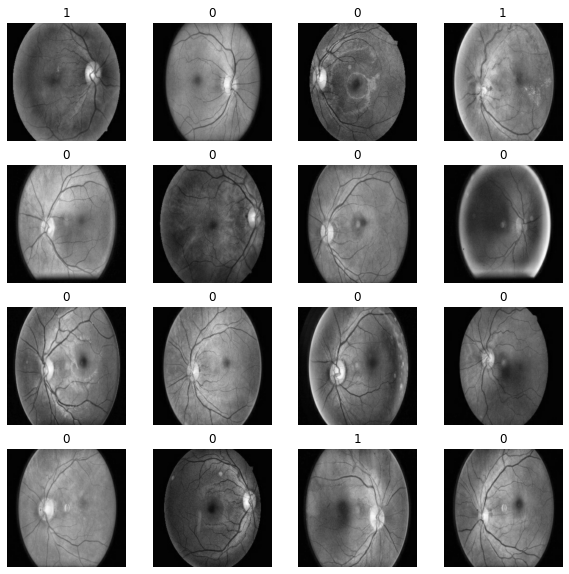

In [10]:
plt.figure(figsize=(10, 10))
for images_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15152 files belonging to 2 classes.
Using 10607 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15152 files belonging to 2 classes.
Using 4545 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.5, seed=None),
    layers.RandomCrop(150, 150, seed=None)
  ]
)

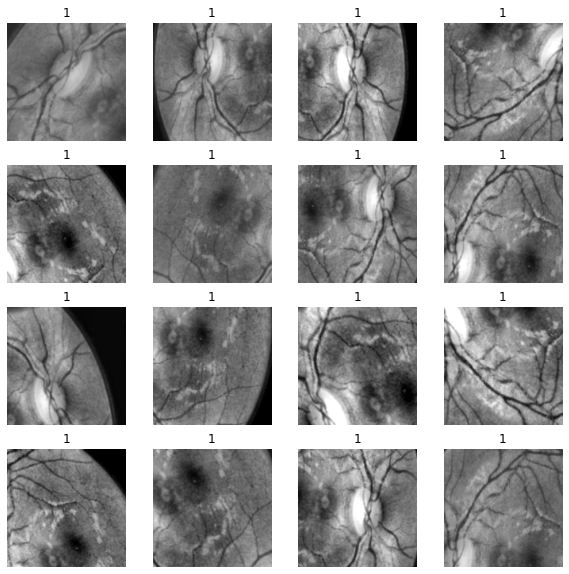

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

In [13]:
num_classes = len(class_names)

# Transfer Learning

In [ ]:
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [14]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.models import Model

In [15]:
base_eff = model = EfficientNetV2L(weights='imagenet', include_top=False)
base_eff.summary()

473176280/473176280 [==============================] - 21s 0us/step
Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   864         ['rescaling[0][0]']              
               

In [16]:
base_eff.trainable = False

In [17]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_eff(image_batch)
print(feature_batch.shape)

(32, 10, 10, 1280)


In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [19]:
prediction_layer = tf.keras.layers.Dense(8, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 8)


In [20]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_eff(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
import time
start_cnn = time.time()

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

path = 'best_model_eff.hdf5'
checkpoint = ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=5)

callback_list = [checkpoint,es]

In [28]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callback_list  
)

Epoch 1/50
332/332 [==============================] - ETA: 0s - loss: 0.6002 - accuracy: 0.6899
Epoch 1: val_accuracy improved from -inf to 0.70473, saving model to best_model_eff.hdf5
332/332 [==============================] - 339s 1s/step - loss: 0.6002 - accuracy: 0.6899 - val_loss: 0.5835 - val_accuracy: 0.7047
Epoch 2/50
332/332 [==============================] - ETA: 0s - loss: 0.5973 - accuracy: 0.6932
Epoch 2: val_accuracy improved from 0.70473 to 0.70693, saving model to best_model_eff.hdf5
332/332 [==============================] - 339s 1s/step - loss: 0.5973 - accuracy: 0.6932 - val_loss: 0.5825 - val_accuracy: 0.7069
Epoch 3/50
332/332 [==============================] - ETA: 0s - loss: 0.5969 - accuracy: 0.6936
Epoch 3: val_accuracy did not improve from 0.70693
332/332 [==============================] - 337s 1s/step - loss: 0.5969 - accuracy: 0.6936 - val_loss: 0.5893 - val_accuracy: 0.7052
Epoch 4/50
332/332 [==============================] - ETA: 0s - loss: 0.6028 - accur

In [29]:
print("Total time: ", time.time() - start_cnn, "seconds")

Total time:  11517.454408168793 seconds


In [30]:
scores = model.evaluate(train_ds)

332/332 [==============================] - 236s 711ms/step - loss: 0.5778 - accuracy: 0.7074


In [31]:
scores = model.evaluate(val_ds)

143/143 [==============================] - 101s 707ms/step - loss: 0.5831 - accuracy: 0.7085


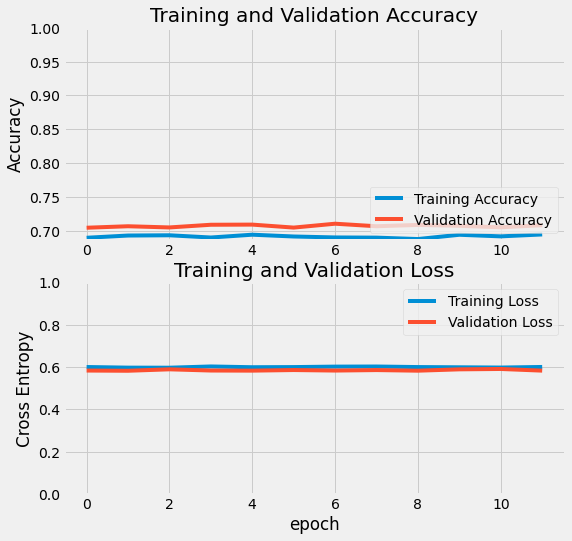

In [32]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Actual label: 0
1/1 [==============================] - 6s 6s/step
[6.5810597e-01 3.4189311e-01 1.5133188e-07 1.4346011e-07 1.1314957e-07
 1.9228216e-07 1.2623721e-07 1.3681347e-07]
predicted label: 0


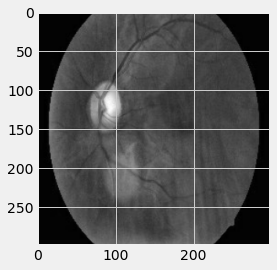

In [33]:
import numpy as np
for images_batch, labels_batch in val_ds.take(1):
    
    first_image = images_batch[5].numpy().astype('uint8')
    first_label = labels_batch[5].numpy()

    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[5])
    print("predicted label:",class_names[np.argmax(batch_prediction[5])])

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 54ms/step


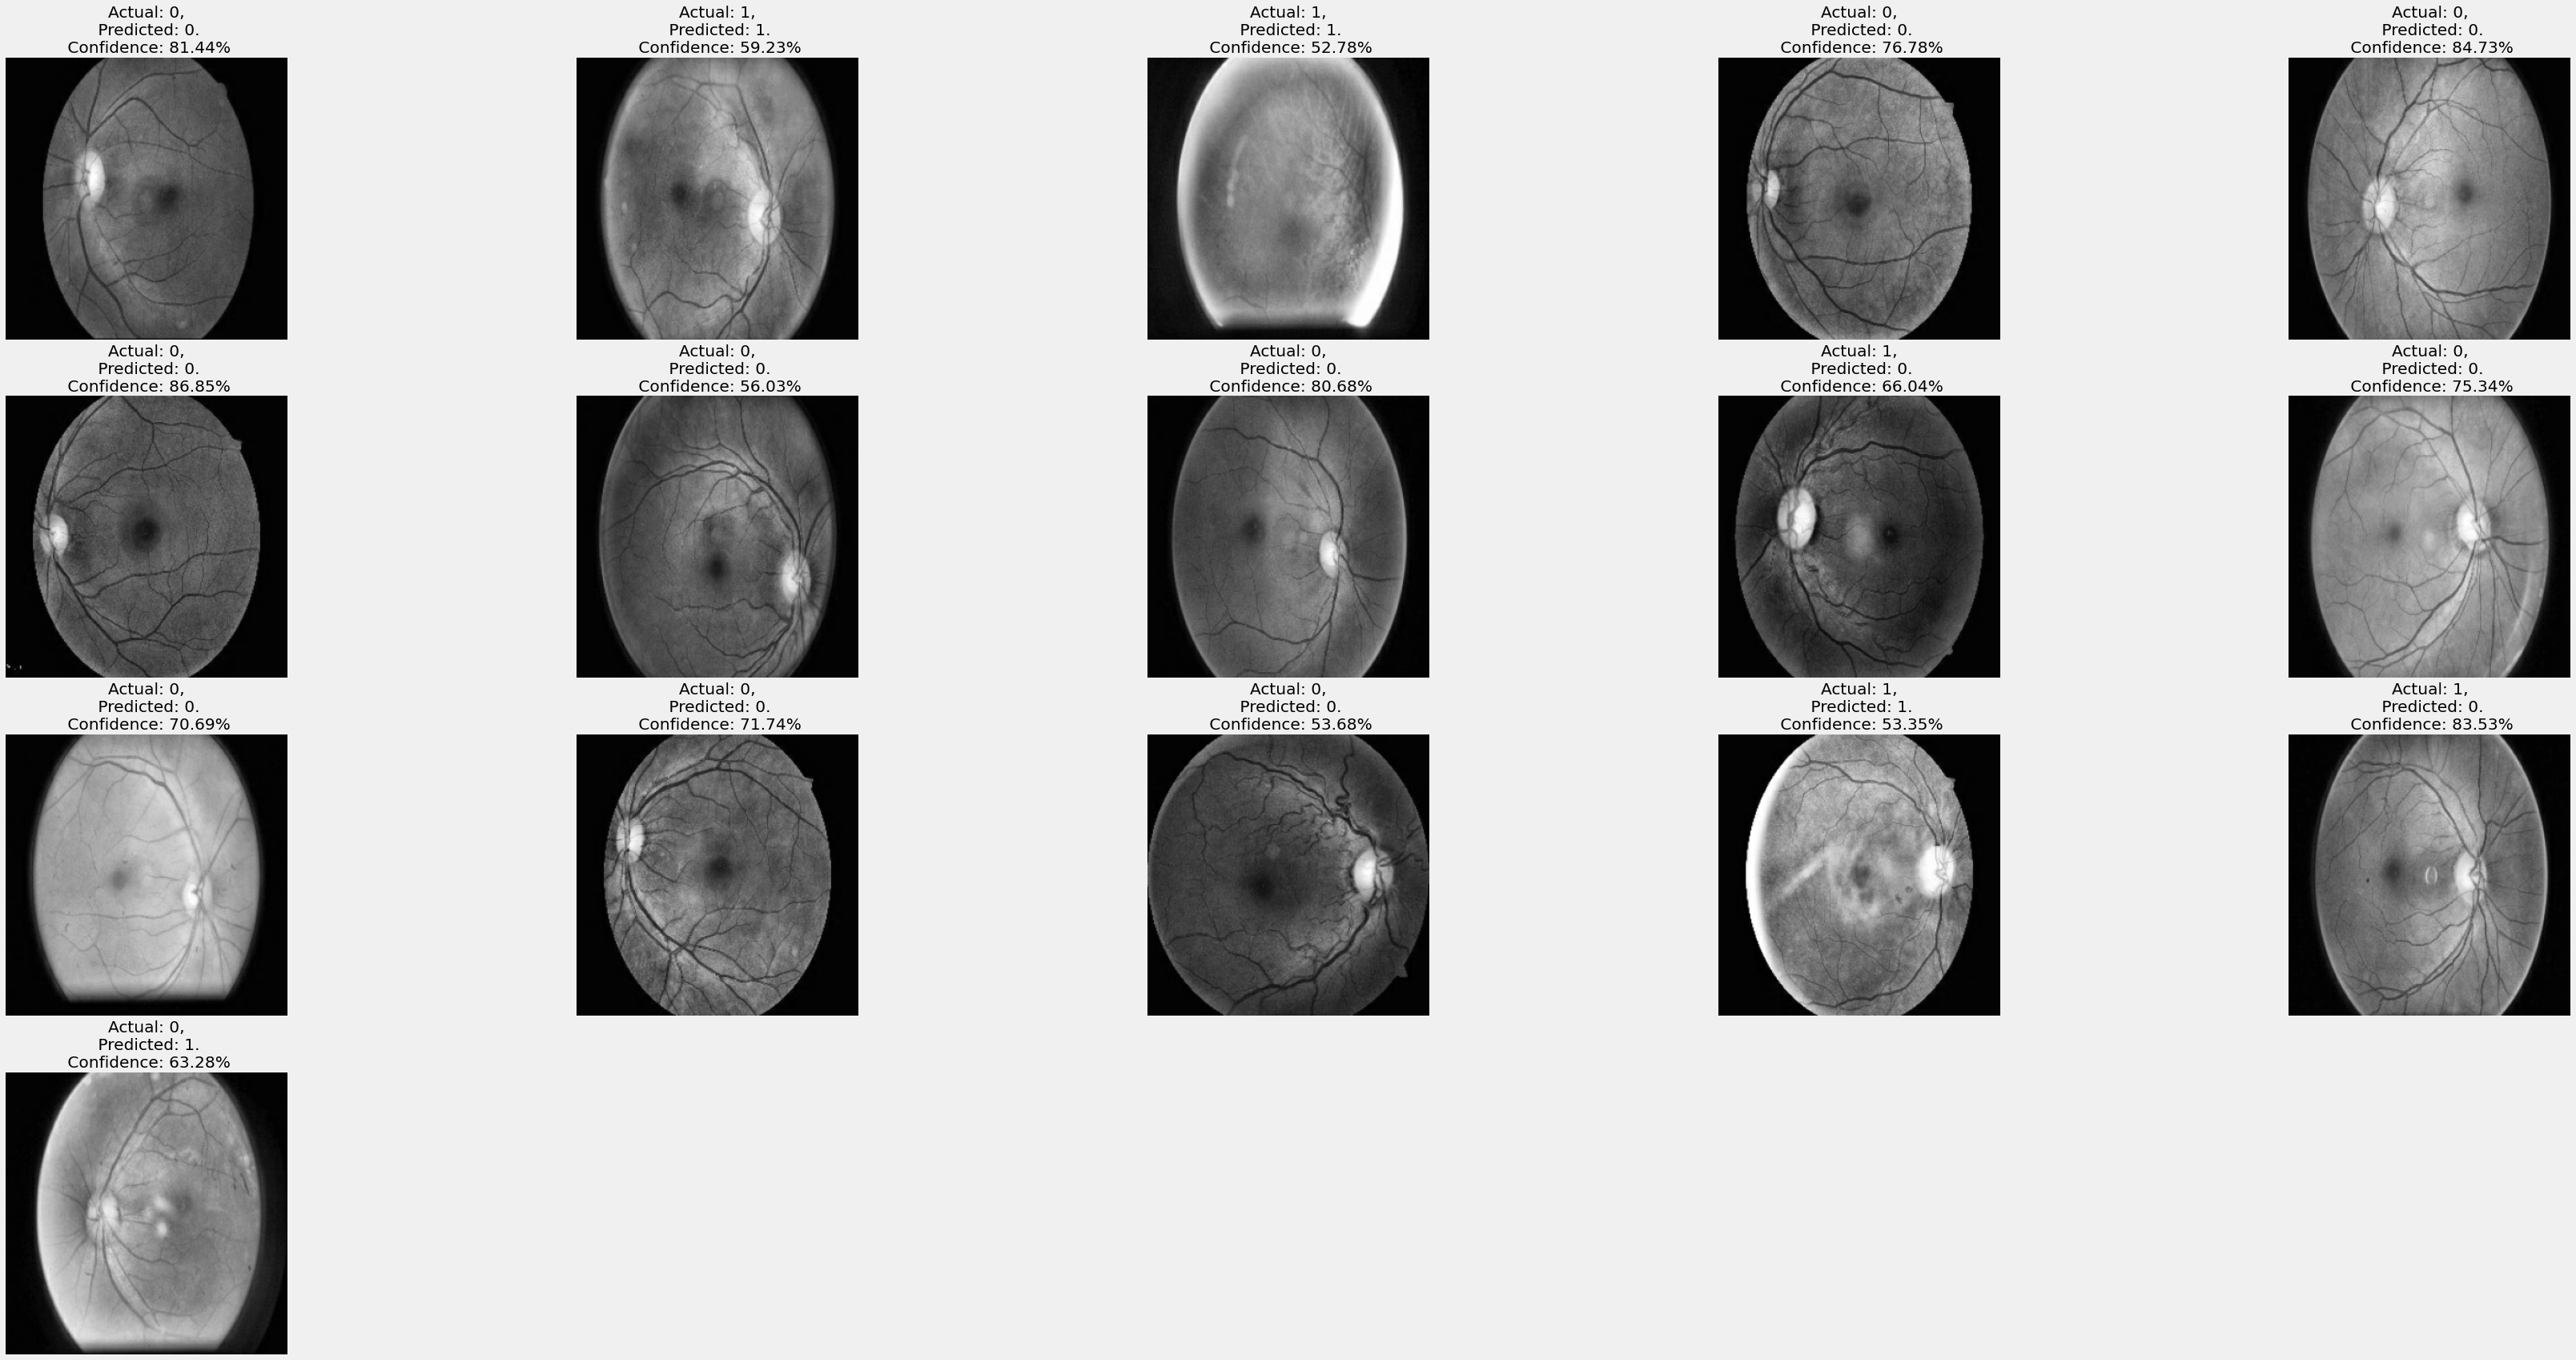

In [39]:
plt.figure(figsize=(55, 35))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [40]:
X = []
y = []
for image,labels in val_ds.take(96):
    for i in image:
        img = i.numpy()
        X.append(img)
    lbl_list = labels.numpy()    
    y.extend(lbl_list)   

In [41]:
x = np.array(X)

In [42]:
y = np.array(y)

In [43]:
x.shape, y.shape

((3072, 299, 299, 3), (3072,))

In [44]:
model.evaluate(x[:3072],y[:3072])

96/96 [==============================] - 68s 709ms/step - loss: 0.5805 - accuracy: 0.7119


[0.5804945826530457, 0.7119140625]

In [45]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(x[:3072])
y_pred_classes = [np.argmax(element) for element in y_pred]
 
print("Classification Report: \n", classification_report(y[:3072], y_pred_classes))

96/96 [==============================] - 67s 699ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.73      0.91      0.81      2038
           1       0.65      0.32      0.43      1034

    accuracy                           0.71      3072
   macro avg       0.69      0.62      0.62      3072
weighted avg       0.70      0.71      0.68      3072



In [46]:
base_eff.trainable = True

In [49]:
print("Number of layers in the base model: ", len(base_eff.layers))
fine_tune_at = 1000

for layer in base_eff.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  1028


In [50]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
epochs = 100
total_epochs =  epochs + 100
history_fine = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=total_epochs,
  initial_epoch=history.epoch[-1],  
  callbacks=callback_list  
)

Epoch 12/200
332/332 [==============================] - ETA: 0s - loss: 0.6578 - accuracy: 0.6664
Epoch 12: val_accuracy did not improve from 0.71067
332/332 [==============================] - 386s 1s/step - loss: 0.6578 - accuracy: 0.6664 - val_loss: 0.5893 - val_accuracy: 0.7025
Epoch 13/200
332/332 [==============================] - ETA: 0s - loss: 0.6001 - accuracy: 0.7003
Epoch 13: val_accuracy did not improve from 0.71067
332/332 [==============================] - 357s 1s/step - loss: 0.6001 - accuracy: 0.7003 - val_loss: 0.5895 - val_accuracy: 0.7107
Epoch 14/200
332/332 [==============================] - ETA: 0s - loss: 0.5779 - accuracy: 0.7148
Epoch 14: val_accuracy improved from 0.71067 to 0.72145, saving model to best_model_eff.hdf5
332/332 [==============================] - 360s 1s/step - loss: 0.5779 - accuracy: 0.7148 - val_loss: 0.5702 - val_accuracy: 0.7215
Epoch 15/200
332/332 [==============================] - ETA: 0s - loss: 0.5667 - accuracy: 0.7210
Epoch 15: val_a

In [52]:
scores = model.evaluate(val_ds)

143/143 [==============================] - 102s 709ms/step - loss: 0.5985 - accuracy: 0.6950


In [53]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(x[:2200])
y_pred_classes = [np.argmax(element) for element in y_pred]
 
print("Classification Report: \n", classification_report(y[:2200], y_pred_classes))

69/69 [==============================] - 56s 735ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.81      0.78      1458
           1       0.56      0.48      0.52       742

    accuracy                           0.70      2200
   macro avg       0.66      0.64      0.65      2200
weighted avg       0.69      0.70      0.69      2200



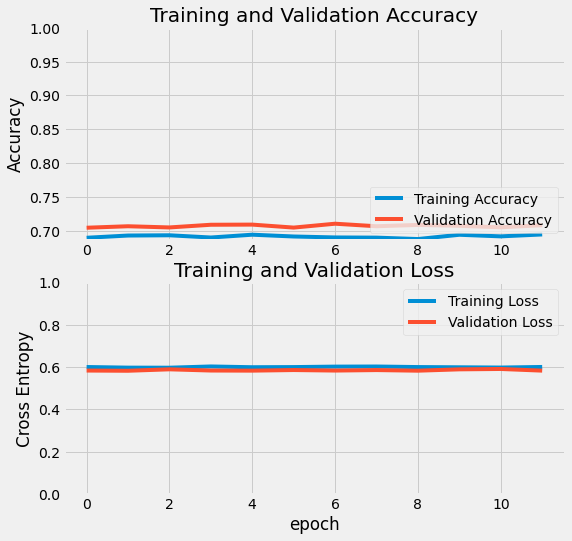

In [54]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()